# Liverpool Goals Analysis
This notebook presents the code I used to generate the figure displayed in the report consituting my contribution to the *Liverpool Analytics Challenge* organised by [Friends of Tracking](https://www.youtube.com/channel/UCUBFJYcag8j2rm_9HkrrA7w). This report is a Medium post that you can find [here](https://medium.com/@gabs.rol43/analysing-liverpool-attack-e6d32c6c9a57#6461).

Before detailing the approach, here are the steps I follow to generate the data I use in this notebook :

1. Before all, I **converted data to Metrica Data Type** because I already developped tools to analyse this kind of dataset. The conversion steps are detailed in [this notebook](https://github.com/Gabsrol/liverpool_analytics_challenge/blob/master/convert_data_to_metrica.ipynb).

2. Then I created a [video clip](https://github.com/Gabsrol/liverpool_analytics_challenge/blob/master/data_outputs/liverpool_analytics_all_goals.mp4) with all goals animation. The code to generate this video is detailed in the notebook [all_goals_animation](https://github.com/Gabsrol/liverpool_analytics_challenge/blob/master/all_goals_animation.ipynb)

3. Then I develop a pitch control model and an off ball scoring opportunity model based on William Spearman [article](https://www.researchgate.net/publication/327139841_Beyond_Expected_Goals) and [video](https://www.youtube.com/watch?v=X9PrwPyolyU&t=1577s). I also used the [Friend of Tracking tutorial](https://www.youtube.com/watch?v=5X1cSehLg6s&t=1227s) on pitch control. The development of this model is available in the notebook [*pitch control and off ball scoring model*](https://github.com/Gabsrol/liverpool_analytics_challenge/blob/master/pitch_control_and_off_ball_scoring_model.ipynb)

4. Then I adapted the precedent notebook to calculate team pitch control surface, team off ball scoring opportunities and individual pitch control surface. The code that realises this task is available [here](https://github.com/Gabsrol/liverpool_analytics_challenge/blob/master/scripts/calculate_pitch_control.py). Careful, it can take several hours to run.

Finally, I was able to create this notebook as well as the notebook [*make contribution animations*](https://github.com/Gabsrol/liverpool_analytics_challenge/blob/master/make_contribution_animations.ipynb) that generates videos for the Medium post.

## Import data

In [2]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

Let's import module created to work with Metrica tracking data. These modules are mainly inspired by Laurie Shaw's tutorials.

In [3]:
from scripts import Metrica_Viz as mviz
from scripts import Metrica_Velocities as mvel

Import Last Row dataset to have plays list

In [4]:
LR_data = pd.read_csv('data_inputs/liverpool_analytics_2019.csv')

For each play, import :
* tracking home --> tracking data for home players (by default liverpool players)
* tracking away --> tracking data for away players
* players_num --> dataframe that associates playersId with their nums
* events --> events data
* off_ball_scoring --> an array of list. Length = nb frames. Each list corresponds to a frame and contains :
    * first item : pitch control surface
    * second item : off ball scoring opportunity surface
    * third item : a dictionnary. Each key is a player and contains pitch control surface for this player
    
Tracking home, away, players_num and events are generated when converting the data.
off_ball_scoring is generated with the script liverpool_analytics_calculate_off_ball_scoring.py

Let's construct a dictionnary plays data containing for each play the data mentionned above.

In [5]:
#plays list
plays = LR_data.play.unique()

#initialize dictionnary
plays_data = {}
for play in plays:
    tracking_home = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/tracking_home.csv')
    tracking_away = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/tracking_away.csv')
    players_num = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/players_num.csv')
    events = pd.read_csv('data_inputs/'+play.replace(' ','_')+'/events.csv')
    try :
        off_ball_scoring = pickle.load(open('data_inputs/'+play.replace(' ','_')+'/off_ball_scoring', 'rb'))
    except:
        plays_data[play] = {'tracking_home':tracking_home}
        plays_data[play]['tracking_away'] = tracking_away
        plays_data[play]['players_num'] = players_num
        plays_data[play]['events'] = events
    else:
        plays_data[play] = {'tracking_home':tracking_home}
        plays_data[play]['tracking_away'] = tracking_away
        plays_data[play]['players_num'] = players_num
        plays_data[play]['events'] = events
        plays_data[play]['off_ball_scoring'] = off_ball_scoring
    

## Shots frame and scorers
Thanks to [animations of all goals](https://github.com/Gabsrol/liverpool_analytics_challenge/blob/master/data_outputs/liverpool_analytics_all_goals.mp4), we look for the frames where the shots were taken and store them in the dataframe goals. 

In [6]:
frames=[132,130,168,232,178,234,120,136,116,163,89,164,152,140,168,244,126,192,96]
scorers=[11,10,10,11,9,11,27,10,27,10,10,26,10,11,27,23,11,11,9]
goals=pd.DataFrame(np.array([frames,scorers]).T,columns=['frame','player_num'],index=plays)

## Where does Liverpool score from?

### Shots location
First, let's plot Liverpool shots location

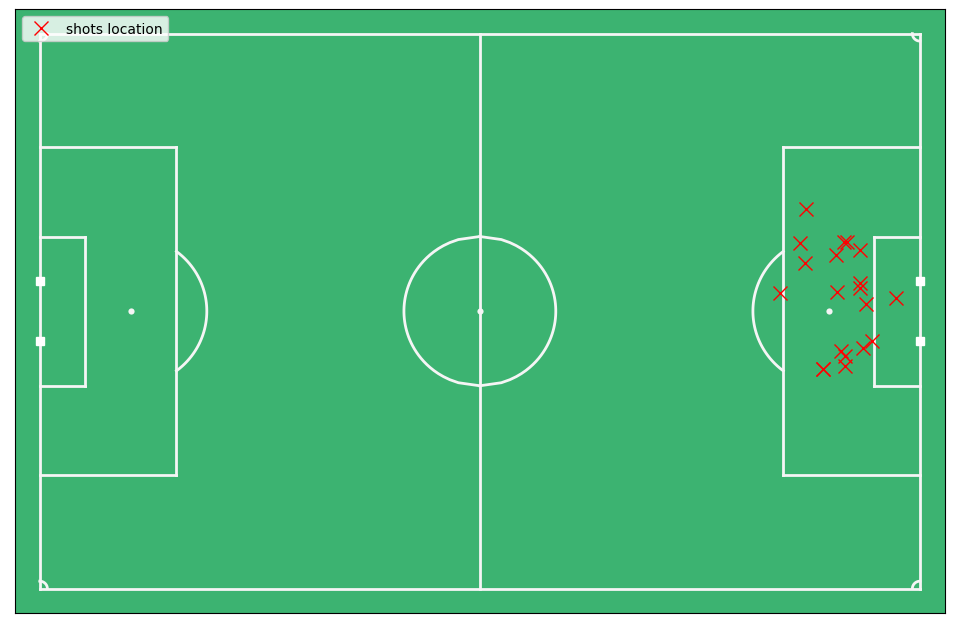

In [7]:
# draw pitch
fig,ax = mviz.plot_pitch()

# for each play draw shot location
for play in plays:
    
    tracking_home = plays_data[play]['tracking_home']
    x_ball = tracking_home['ball_x'].values
    y_ball = tracking_home['ball_y'].values
    
    # goal frame
    goal_frame=goals.loc[play,'frame']
    
    # convert as Liverpool attacked in the same direction (right)
    if x_ball[-1]<0:
        x_ball = - x_ball
        y_ball = - y_ball
    
    ax.plot(x_ball[goal_frame],y_ball[goal_frame],'rx',markersize=10)
    
    # legend
    if play==plays[0]:
        ax.plot(x_ball[goal_frame],y_ball[goal_frame],'rx',markersize=10,label='shots location')
ax.legend(loc='upper left')

Of the 19 goals we're looking at, all of them are scored from inside the box. But then how does Liverpool get the ball into the penalty area?
### Last pass and ball trajectory before shot

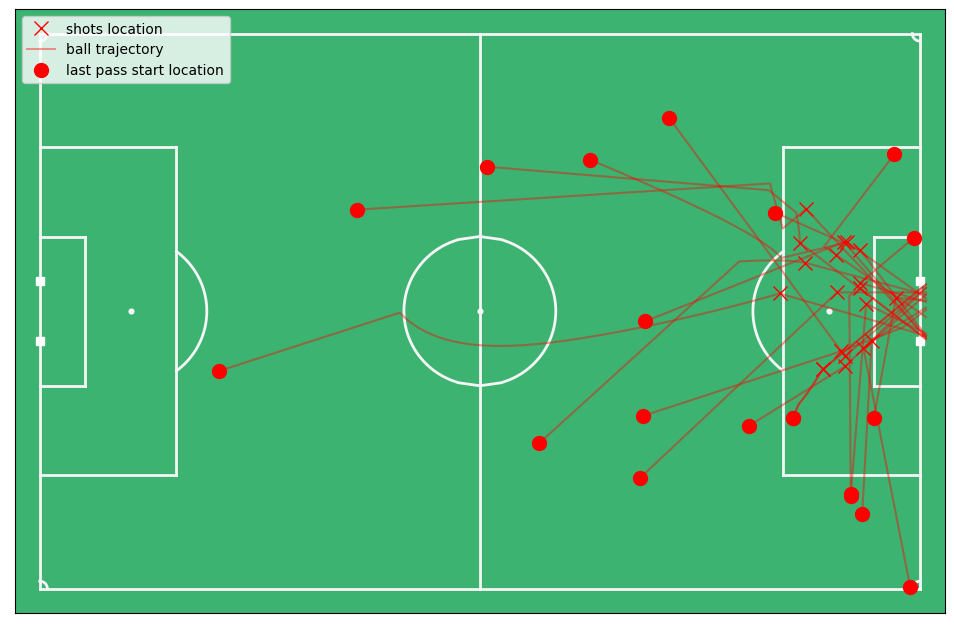

In [8]:
# draw pitch
fig,ax = mviz.plot_pitch()

# for each play draw ball's trajectory
for play in plays:
    tracking_home = plays_data[play]['tracking_home']
    x_ball = tracking_home['ball_x'].values
    y_ball = tracking_home['ball_y'].values
    
    # get last pass frame
    events = plays_data[play]['events'].copy()
    last_pass_frame = events.query('Type=="PASS"')['Start Frame'].max()
    
    # goal frame
    goal_frame=goals.loc[play,'frame']
    
    # convert as Liverpool attacked in the same direction (right)
    if x_ball[-1]<0:
        x_ball = - x_ball
        y_ball = - y_ball
    
    ax.plot(x_ball[goal_frame],y_ball[goal_frame],'rx',markersize=10)
    ax.plot(x_ball[last_pass_frame:],y_ball[last_pass_frame:],'r',alpha=0.4)
    ax.plot(x_ball[last_pass_frame],y_ball[last_pass_frame],'ro',markersize=10)
    
    # legend
    if play==plays[0]:
        ax.plot(x_ball[goal_frame],y_ball[goal_frame],'rx',markersize=10,label='shots location')
        ax.plot(x_ball[last_pass_frame:],y_ball[last_pass_frame:],'r',alpha=0.4,label='ball trajectory')
        ax.plot(x_ball[last_pass_frame],y_ball[last_pass_frame],'ro',markersize=10,label='last pass start location')
        
ax.legend(loc='upper left')

it is noticeable that the strikers mostly receive the ball in the area and move very little with it before shooting. Thus, out of these 19 goals the player is mostly put in a shooting situation by his movement and passing and not by his dribbling (except for the goal against Southampton where Salah leads the ball from his side on a counter attack). To prove it, we can make plot the distance travelled by the striker before shooting to see that all shots (expected one) are taken after less than 10 meters run.

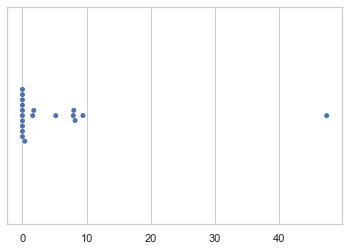

In [9]:
import seaborn as sns

sns.set(style="whitegrid")
distances=[]
# for each play calculating distance between last pass reception and shot
for play in plays:
    tracking_home = plays_data[play]['tracking_home']
    x_ball = tracking_home['ball_x'].values
    y_ball = tracking_home['ball_y'].values
    
    # get last pass end frame
    events = plays_data[play]['events'].copy()
    last_pass_frame = int(events.query('Type=="PASS"')['End Frame'].max())
    
    # goal frame
    goal_frame=goals.loc[play,'frame']
    
    x_ball=np.diff(x_ball[last_pass_frame:goal_frame+1])
    y_ball=np.diff(y_ball[last_pass_frame:goal_frame+1])
    
    distance=np.sum(np.sqrt(x_ball**2+y_ball**2))
    
    distances.append(distance)

ax = sns.swarmplot(x=distances)

Actually, Liverpool use two main ways of bringing the ball into the penalty area. The first is to make a long pass to the back of the defence. This pass is often risky, but if successful, it provides a good opportunity to shoot. The second way is to spread the ball over the wings and then cross.

## How does Liverpool bring the ball into the box ?

### Passes behind the defence
On 12 of the 19 shots, Liverpool use a pass in the back of the defence to create a scoring opportunity. Let's look at those passes.
#### Risky passes...
Let's have a look at the pass success probability, to evaluate it, we use pitch control value at target position when pass starts 

In [10]:
passes_behind_defense=pd.DataFrame({'play':['Liverpool [3] - 0 Bournemouth',
                                            'Bayern 0 - [1] Liverpool',
                                            'Porto 0 - [2] Liverpool',
                                            'Liverpool [3] - 0 Norwich',
                                            'Liverpool [2] - 1 Chelsea',
                                            'Liverpool [2] - 1 Newcastle',
                                            'Genk 0 - [3] Liverpool',
                                            'Liverpool [2] - 0 Man City',
                                            'Liverpool [1] - 0 Everton',
                                            'Liverpool [2] - 0 Everton',
                                            'Bournemouth 0 - 3 Liverpool',
                                            'Liverpool [1] - 0 Watford',
                                            
                                           ],
                                    'frame':[42,16,174,80,82,48,118,100,112,62,82,98]},columns=['play','frame'])

passes_behind_defense.set_index('play',inplace=True)

In [11]:
pass_proba = []
for p in passes_behind_defense.index:
    
    off_ball_scoring = plays_data[p]['off_ball_scoring']
    events = plays_data[p]['events']
    
    pass_start_frame = passes_behind_defense.loc[p]['frame']
    pass_ = events.query('`Start Frame`==@pass_start_frame')
    end_x = int((pass_['End X']+106/2)/106*50)
    end_y = int((pass_['End Y']+68/2)/68*32)

    pitch_control_at_frame = off_ball_scoring[int(pass_start_frame/2)][0]

    pass_proba.append(round(pitch_control_at_frame[end_y,end_x]*100))

passes_behind_defense['proba'] = pass_proba

In [12]:
passes_behind_defense

,frame,proba
play,,
Liverpool [3] - 0 Bournemouth,42,3.0
Bayern 0 - [1] Liverpool,16,7.0
Porto 0 - [2] Liverpool,174,50.0
Liverpool [3] - 0 Norwich,80,26.0
Liverpool [2] - 1 Chelsea,82,42.0
Liverpool [2] - 1 Newcastle,48,3.0
Genk 0 - [3] Liverpool,118,19.0
Liverpool [2] - 0 Man City,100,5.0
Liverpool [1] - 0 Everton,112,3.0


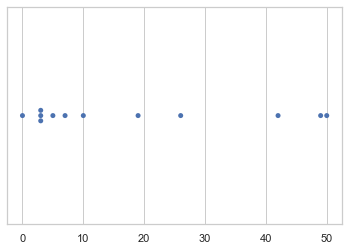

In [13]:
ax = sns.swarmplot(x=pass_proba)

We observe that most of these passes are risky ones as the success probability is week

#### But a huge opportunity to score
Although these passes are risk, they create opportunities. Indeed, in the case these passes are followed by a goal, we don't have to prove it as they have lead to a goal. If they are not followed by a shot, we can quantify their value with off ball scoring opportunity. 

In [14]:
scoring_gained = []
scoring_start = []
scoring_end = []
for p in passes_behind_defense.index:
    
    off_ball_scoring = plays_data[p]['off_ball_scoring']
    events = plays_data[p]['events']
    
    pass_start_frame = passes_behind_defense.loc[p]['frame']
    
    if pass_start_frame!=events['Start Frame'].max():
        pass_ = events.query('`Start Frame`==@pass_start_frame')
        pass_end_frame = pass_['End Frame']

        scoring_opp_start = np.sum(off_ball_scoring[int(pass_start_frame/2)][1])
        scoring_opp_end = np.sum(off_ball_scoring[int(pass_end_frame/2)][1])

        scoring_start.append(scoring_opp_start)
        scoring_end.append(scoring_opp_end)
        scoring_gained.append((scoring_opp_end-scoring_opp_start))
        
    else :
        scoring_start.append(0)
        scoring_end.append(0)
        scoring_gained.append(0)
    
passes_behind_defense['gain'] = scoring_gained
passes_behind_defense['scoring_start'] = scoring_start
passes_behind_defense['scoring_end'] = scoring_end

In [15]:
passes_behind_defense

,frame,proba,gain,scoring_start,scoring_end
play,,,,,
Liverpool [3] - 0 Bournemouth,42,3.0,4.117748,0.433308,4.551056
Bayern 0 - [1] Liverpool,16,7.0,0.000000,0.000000,0.000000
Porto 0 - [2] Liverpool,174,50.0,0.000000,0.000000,0.000000
Liverpool [3] - 0 Norwich,80,26.0,0.000000,0.000000,0.000000
Liverpool [2] - 1 Chelsea,82,42.0,2.431143,1.003437,3.434580
Liverpool [2] - 1 Newcastle,48,3.0,0.000000,0.000000,0.000000
Genk 0 - [3] Liverpool,118,19.0,0.000000,0.000000,0.000000
Liverpool [2] - 0 Man City,100,5.0,0.000000,0.000000,0.000000
Liverpool [1] - 0 Everton,112,3.0,0.000000,0.000000,0.000000


All of these risky passes result in a gain of scoring opportunity.

#### Move analysis
For these passes to be successful, you need a good passer, but also a receiver in motion with good timing. Ideally, the attacker should be set between two defenders, ready to run to get the defenders up to speed and have time to control the ball.

Let's analyse Mane's goal against Newcastle

Text(0, 0.5, "Mane's pitch control")

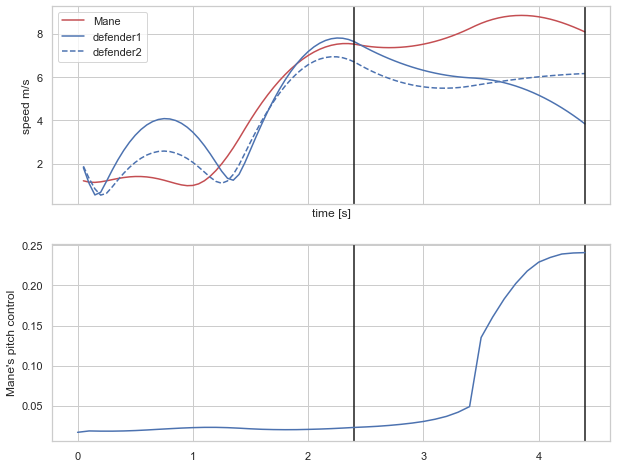

In [16]:
play='Liverpool [2] - 1 Newcastle'
tracking_home = plays_data[play]['tracking_home']
tracking_away = plays_data[play]['tracking_away']
events = plays_data[play]['events']

#calculate players' velocities
tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')

# off_ball is a list of lists. Each list corresponds to a frame and contains pitch control surface for team, 
# off ball scoring surface for team and a dictionnary with individual player's pitch control surface.
off_ball = plays_data[play]['off_ball_scoring']
players_num = plays_data[play]['players_num']
players_num.columns=['playerid','num']
mane_id = players_num.query('num==10')['playerid'].values[0]

start_pass = int(events.query('Type=="PASS"')['Start Frame'].max())
end_pass = int(events.query('Type=="PASS"')['End Frame'].max())
speed = tracking_home['Home_'+str(mane_id)+'_speed']
time = tracking_home['Time [s]']
pitch_control = [np.sum(off[2]['Home_'+str(mane_id)+'_'])/32/50 for off in off_ball]

speed_closest_defender1 = tracking_away['Away_2512_speed']
speed_closest_defender2 = tracking_away['Away_2513_speed']

fig,ax=plt.subplots(2,1,figsize=(10,8),sharex=True)
ax[0].plot(time[:end_pass+1],speed[:end_pass+1],'r',label='Mane')
ax[0].plot(time[:end_pass+1],speed_closest_defender1[:end_pass+1],'b',label='defender1')
ax[0].plot(time[:end_pass+1],speed_closest_defender2[:end_pass+1],'b--',label='defender2')
ax[0].axvline(time[start_pass],color='k')
ax[0].axvline(time[end_pass],color='k')
ax[1].axvline(time[start_pass],color='k')
ax[1].axvline(time[end_pass],color='k')
ax[1].plot(time[:end_pass+1:2],pitch_control[:int(end_pass/2)+1])

ax[0].legend(loc='upper left')
ax[0].set_xlabel('time [s]')
ax[0].set_ylabel("speed m/s")
ax[1].set_ylabel("Mane's pitch control")

### Crosses


#### Players position and scorers move for 3 crosses

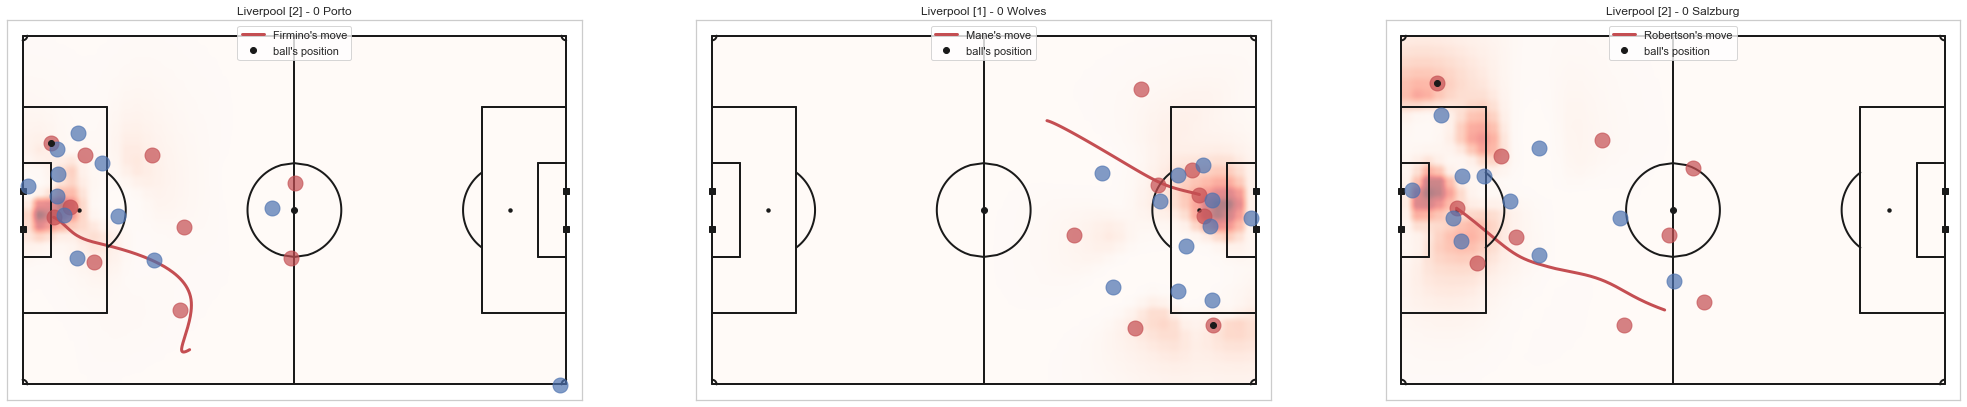

In [17]:
# cross plays list
cross_plays=['Liverpool [2] - 0 Porto','Liverpool [1] - 0 Wolves','Liverpool [2] - 0 Salzburg']

# creat subplots
fig,ax=plt.subplots(1,3,figsize=(35,8))

# scorers num
scorers=['13','1776','12']
scorers_names=['Firmino','Mane','Robertson']

for k in range(3):
    
    play=cross_plays[k]
    tracking_home = plays_data[play]['tracking_home']
    tracking_away = plays_data[play]['tracking_away']
    events = plays_data[play]['events']
    tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
    tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')
    off_ball = plays_data[play]['off_ball_scoring']
    players_num = plays_data[play]['players_num']
    
    #cross frame
    cross_frame=int(events.query('Type=="PASS"')['Start Frame'].max())
    
    # plot scorer
    x = tracking_home['Home_'+scorers[k]+'_x'].iloc[:cross_frame+1]
    y = tracking_home['Home_'+scorers[k]+'_y'].iloc[:cross_frame+1]
    ax[k].plot(x,y,'r',linewidth=3,label=scorers_names[k]+"'s move")
    
    #ball's legend
    ax[k].plot(0,0,'ko',label="ball's position")
    
    #legend
    ax[k].legend(loc='upper center')
    
    # title
    ax[k].set_title(play)
    
    PPCF=off_ball[int(cross_frame/2)][1]
    play=cross_plays[k]
    mviz.plot_pitch(field_color='white',figax=(fig,ax[k]))
    mviz.plot_frame(tracking_home.iloc[cross_frame],tracking_away.iloc[cross_frame],figax=(fig,ax[k]),annotate=False,include_player_velocities=False,PlayerMarkerSize=15)
    field_dimen = (106.,68.,)
    n_grid_cells_x = 50
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y)
    cmap = 'Reds'#plt.cm.Reds
    #im=ax[k].imshow(np.flipud(PPCF), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,cmap=cmap,alpha=0.5)


In [18]:
import importlib
importlib.reload(mviz)

<module 'scripts.Metrica_Viz' from '/Users/gabin/Ordinateur/Documents/Informatique/liverpool_analytics_challenge/scripts/Metrica_Viz.py'>

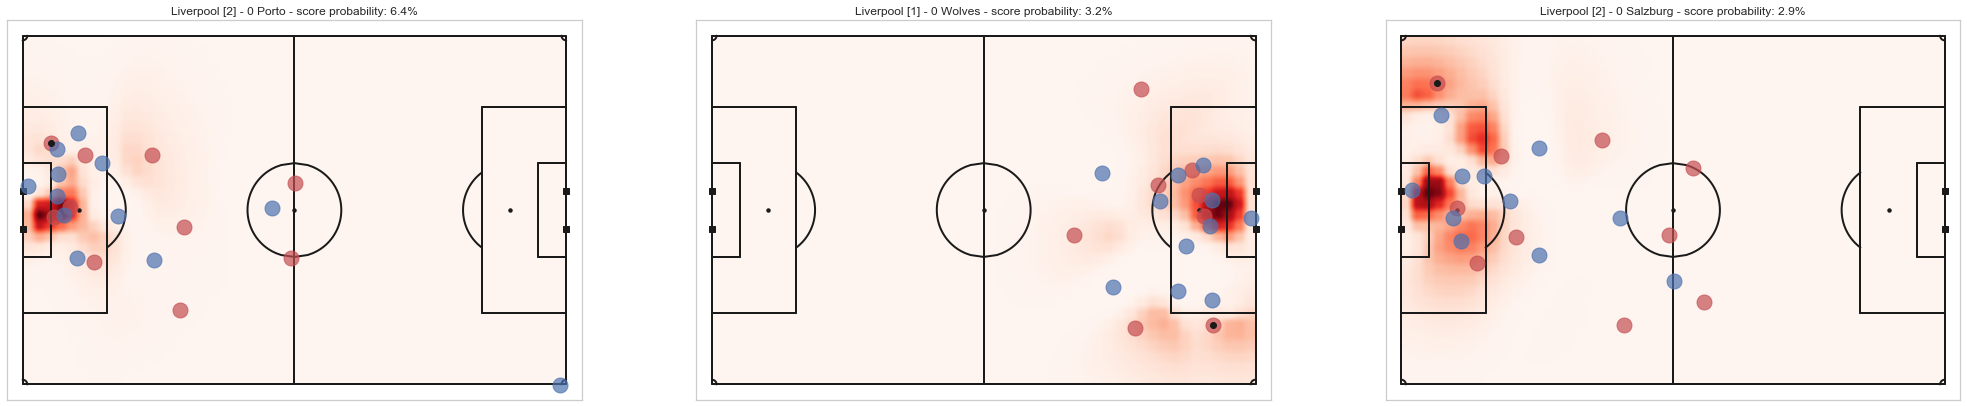

In [19]:
# cross plays list
cross_plays=['Liverpool [2] - 0 Porto','Liverpool [1] - 0 Wolves','Liverpool [2] - 0 Salzburg']

# creat subplots
fig,ax=plt.subplots(1,3,figsize=(35,12))

# scorers num
scorers=['13','1776','12']
scorers_names=['Firmino','Mane','Robertson']

for k in range(3):
    
    play=cross_plays[k]
    tracking_home = plays_data[play]['tracking_home']
    tracking_away = plays_data[play]['tracking_away']
    events = plays_data[play]['events']
    tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
    tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')
    off_ball = plays_data[play]['off_ball_scoring']
    players_num = plays_data[play]['players_num']
    
    #cross frame
    cross_frame=int(events.query('Type=="PASS"')['Start Frame'].max())
    
    scoring_opportunity=off_ball[int(cross_frame/2)][1]
    play=cross_plays[k]
    mviz.plot_pitch(field_color='white',figax=(fig,ax[k]))
    mviz.plot_frame(tracking_home.iloc[cross_frame],tracking_away.iloc[cross_frame],figax=(fig,ax[k]),annotate=False,include_player_velocities=False,PlayerMarkerSize=15)
    field_dimen = (106.,68.,)
    n_grid_cells_x = 50
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y)
    cmap = 'Reds'#plt.cm.Reds
    
    # annotate scoring chance
    ax[k].set_title(play+' - '+'score probability: '+str(round(np.sum(scoring_opportunity),1))+'%')
    
    im=ax[k].imshow(np.flipud(scoring_opportunity), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,cmap=cmap)

## Liverool increase their chance of scoring

Liverpool [3] - 0 Bournemouth
Southampton 1 - [2] Liverpool
Porto 0 - [2] Liverpool


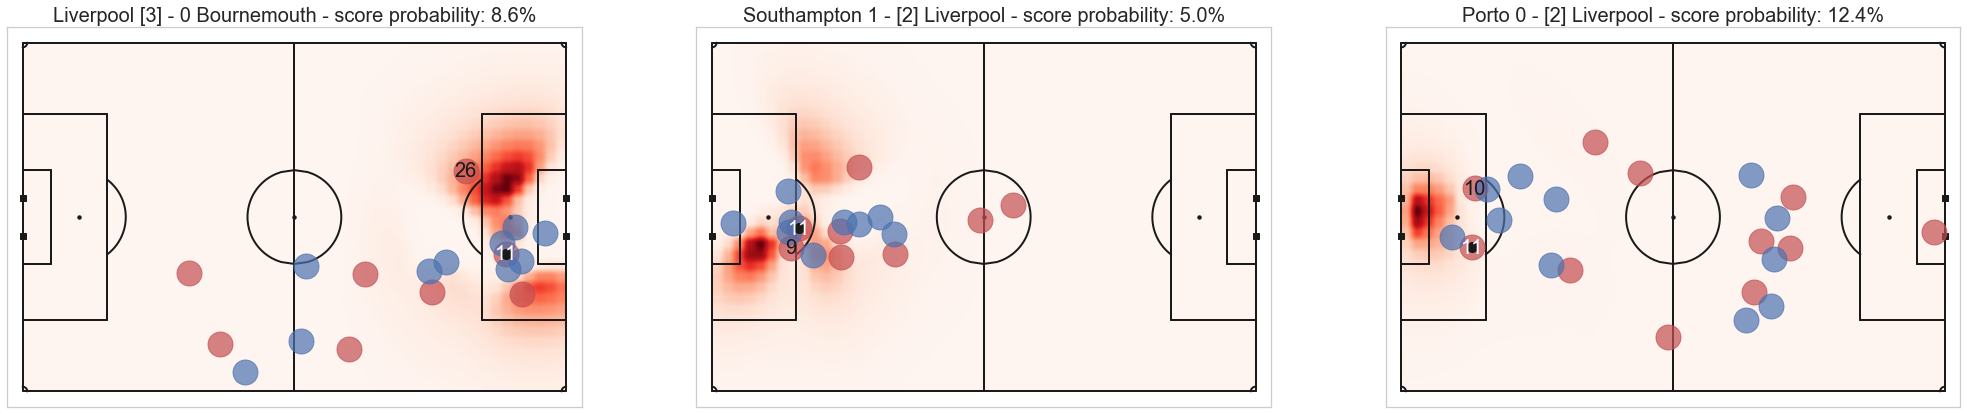

In [104]:
# goals list
goals_plays=['Liverpool [3] - 0 Bournemouth','Southampton 1 - [2] Liverpool','Porto 0 - [2] Liverpool']

# creat subplots
fig,ax=plt.subplots(1,3,figsize=(35,16))

# scorers num
scorers=['331','15','12']
scorers_num=['11','11','11']
players_on_good_position=['648','3969','2492']
players_on_good_position_num=['26','9','10']

for k in range(3):
    
    play=goals_plays[k]
    print(play)
    tracking_home = plays_data[play]['tracking_home']
    tracking_away = plays_data[play]['tracking_away']
    events = plays_data[play]['events']
    tracking_home = mvel.calc_player_velocities(tracking_home,smoothing=True,filter_='moving_average')
    tracking_away = mvel.calc_player_velocities(tracking_away,smoothing=True,filter_='moving_average')
    off_ball = plays_data[play]['off_ball_scoring']
    players_num = plays_data[play]['players_num']
    
    #shot frame
    shot_frame=int(goals.loc[play]['frame'])
    
    scoring_opportunity=off_ball[int(shot_frame/2)][1]
    mviz.plot_pitch(field_color='white',figax=(fig,ax[k]))
    mviz.plot_frame(tracking_home.iloc[shot_frame],tracking_away.iloc[shot_frame],figax=(fig,ax[k]),annotate=False,include_player_velocities=False,PlayerMarkerSize=25)
    field_dimen = (106.,68.,)
    n_grid_cells_x = 50
    n_grid_cells_y = int(n_grid_cells_x*field_dimen[1]/field_dimen[0])
    xgrid = np.linspace( -field_dimen[0]/2., field_dimen[0]/2., n_grid_cells_x)
    ygrid = np.linspace( -field_dimen[1]/2., field_dimen[1]/2., n_grid_cells_y)
    cmap = 'Reds'#plt.cm.Reds
    
    # highlight scorers and players on good position to score
    ax[k].text(tracking_home.iloc[shot_frame]['Home_'+scorers[k]+'_x'],tracking_home.iloc[shot_frame]['Home_'+scorers[k]+'_y'],scorers_num[k],fontsize=20,color='white',horizontalalignment='center', verticalalignment='center')
    ax[k].text(tracking_home.iloc[shot_frame]['Home_'+players_on_good_position[k]+'_x'],tracking_home.iloc[shot_frame]['Home_'+players_on_good_position[k]+'_y'],players_on_good_position_num[k],fontsize=20,color='k',horizontalalignment='center', verticalalignment='center')
    
    # annotate scoring chance
    ax[k].set_title(play+' - '+'score probability: '+str(round(np.sum(scoring_opportunity),1))+'%',fontsize=20)
    
    im=ax[k].imshow(np.flipud(scoring_opportunity), extent=(np.amin(xgrid), np.amax(xgrid), np.amin(ygrid), np.amax(ygrid)),interpolation='hanning',vmin=0.0,cmap=cmap,aspect='equal')